In [1]:
from lattice import *
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import pandas as pd
import numpy as np
from IPython.display import display

def describe(l: Lattice2D, E_amp, omega):
    Lx, Ly = l.geometry.dimensions
    t_hop = l.simulation_parameters.t_hop # Assuming t_hop is stored in sim params

    # Determine v_F based on geometry type and hopping parameter
    # Assuming lattice constant a=1 for velocity units
    if isinstance(l.geometry, HexagonalLatticeGeometry) or isinstance(l.geometry, BrickwallLatticeGeometry):
        # For graphene-like lattices, v_F = 3/2 |t| a. Assuming a=1.
        v_F = 1.5 * abs(t_hop)
        geom_type = type(l.geometry).__name__
    elif isinstance(l.geometry, RectangularLatticeGeometry):
        # For a square lattice, max group velocity is 2|t|a. Assuming a=1.
        # This is an approximation as v_F depends on Fermi level.
        v_F = 2.0 * abs(t_hop)
        geom_type = type(l.geometry).__name__ # Could be SquareLatticeGeometry if it inherits
    else:
        v_F = np.nan
        geom_type = type(l.geometry).__name__


        
    W = np.max(l.eigen_energies) - np.min(l.eigen_energies)

    # Calculate derived physical quantities
    omega_R = (2) * (2 * np.pi * v_F / Ly) if Ly > 0 and not np.isnan(v_F) else np.inf
    l_WS = (W / E_amp) if E_amp > 0 and not np.isnan(W) else np.inf
    xi = (2 * np.pi * v_F / omega) if omega > 0 and not np.isnan(v_F) else np.inf
    delta_ky = np.pi / (Ly + 1) if Ly > 0 else np.inf # Assuming effective length Ly+1 for modes
    delta_E = v_F * delta_ky if not np.isnan(v_F) else np.nan

    # Create a dictionary to hold the parameters and their values
    params = {
        "Parameter": [
            "Lattice Geometry",
            "Lattice Size (Lx, Ly)",
            "Hopping Parameter (t)",
            "Fermi Velocity (v_F)",
            "Bandwidth (W)",
            "E Field Amplitude (E_amp)",
            "E Field Frequency (ω)",
            "Real Space Reflection Bound (ω_R)",
            "Wannier-Stark Length (l_WS)",
            "Real Space Oscillation Wavelength (ξ)",
            "Mode Spacing (Δk_y)",
            "Energy Level Spacing (ΔE)",
        ],
        "Value": [
            geom_type,
            f"({Lx}, {Ly})",
            f"{t_hop:.2f}",
            f"{v_F:.3f}" if not np.isnan(v_F) else "N/A",
            f"{W:.3f}" if not np.isnan(W) else "N/A",
            f"{E_amp:.1e}",
            f"{omega:.1f}",
            f"{omega_R:.3f}" if np.isfinite(omega_R) else "Inf",
            f"{l_WS:.1f}" if np.isfinite(l_WS) else "Inf",
            f"{xi:.3f}" if np.isfinite(xi) else "Inf",
            f"{delta_ky:.3f}" if np.isfinite(delta_ky) else "Inf",
            f"{delta_E:.3f}" if not np.isnan(delta_E) else "N/A",
        ],
        "Units / Notes": [
            "", # Geometry type
            "", # Dimensions
            "", # Hopping energy unit
            "a|t| (a=1)", # Velocity unit
            "|t|", # Energy unit
            "", # Field unit
            "", # Frequency unit
            "|t|", # Energy unit
            "a (a=1)", # Length unit
            "a (a=1)", # Length unit
            "1/a (a=1)", # Wavenumber unit
            "|t|", # Energy unit
        ]
    }

    # Create and display a pandas DataFrame for a clean table format
    df = pd.DataFrame(params)
    display(df)

In [65]:
E = 1e-5
omega = 4 / np.pi

l = Lattice2D(
    RectangularLatticeGeometry((13, 41)),
    SimulationParameters(
        t_hop=-1,
        E_amplitude=FieldAmplitudeGenerator.ramped_oscillation(E, omega, 10),
        E_direction=np.array([0, 1]),
        h=0.01,
        T=20,
        substeps=8,
    ),
)

describe(l, E, omega)

# l.density_matrix = 1/12 * np.diag([1 if 3<l.geometry.site_to_position(i)[1]<6 else 0 for i in range(l.N)])
l.evolve(first_snapshot_step=0 * 8 / 0.01, decay_time=float("inf"))

/Users/leonard/dev/projects/university/orbitronics_research_project/lattice/lattice.py:66: UserWarning: Site number should be even--then integer # of states can be set with half occupation.
  warnings.warn(


Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


,Parameter,Value,Units / Notes
0,Lattice Geometry,RectangularLatticeGeometry,
1,"Lattice Size (Lx, Ly)","(13, 41)",
2,Hopping Parameter (t),-1.00,
3,Fermi Velocity (v_F),2.000,a|t| (a=1)
4,Bandwidth (W),7.889,|t|
5,E Field Amplitude (E_amp),1.0e-05,
6,E Field Frequency (ω),1.3,
7,Real Space Reflection Bound (ω_R),0.613,|t|
8,Wannier-Stark Length (l_WS),788852.7,a (a=1)
9,Real Space Oscillation Wavelength (ξ),9.870,a (a=1)


100%|██████████| 16000/16000 [04:52<00:00, 54.66it/s]


In [66]:
d = SimulationData(l, omega)

100%|██████████| 2001/2001 [00:13<00:00, 150.36it/s]


(<Figure size 1000x1200 with 4 Axes>,
 array([<Axes: ylabel='$P_y(t) (e a^{-1})$'>,
        <Axes: ylabel='$\\frac{\\partial P_y}{\\partial t}~(e t_{\\rm hop} a^{-1} \\hbar^{-1})$'>,
        <Axes: ylabel='$P_{\\rm orb, x}(t)~(e a^{-1})$'>,
        <Axes: xlabel='t', ylabel='$\\frac{\\partial P_{\\rm orb, x}(t)}{\\partial t}~(e t_{\\rm hop} a^{-1} \\hbar^{-1})$'>],
       dtype=object))

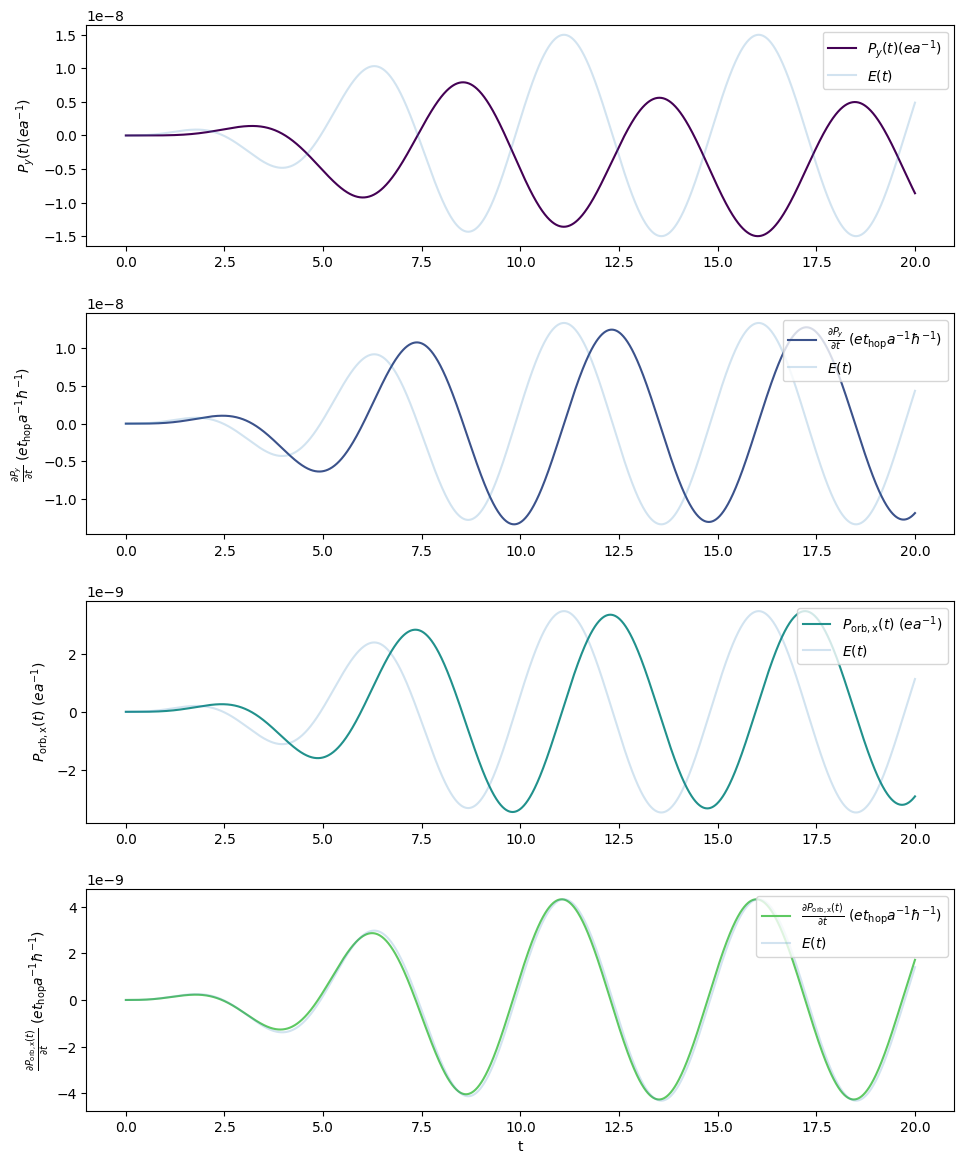

In [67]:
d.plot_simulation_time_series()

In [29]:
l.save_current_density_animation("Low_E_long_ramp.mp4", fps=10, sample_every=10)

Generating animation: 100%|██████████| 200/200 [07:22<00:00,  2.21s/frame]


In [22]:
d = SimulationData(l, omega)

100%|██████████| 2001/2001 [00:14<00:00, 136.79it/s]


In [76]:
import pickle

with open("Low_E_long_ramp.pickle", "wb") as f:
    pickle.dump(d, f)

In [25]:
import pickle
with open("Low_E_long_ramp.pickle", "rb") as f:
    d = pickle.load(f)

(<Figure size 1000x1200 with 4 Axes>,
 array([<Axes: ylabel='$P_y(t) (e a^{-1})$'>,
        <Axes: ylabel='$\\frac{\\partial P_y}{\\partial t}~(e t_{\\rm hop} a^{-1} \\hbar^{-1})$'>,
        <Axes: ylabel='$P_{\\rm orb, x}(t)~(e a^{-1})$'>,
        <Axes: xlabel='t', ylabel='$\\frac{\\partial P_{\\rm orb, x}(t)}{\\partial t}~(e t_{\\rm hop} a^{-1} \\hbar^{-1})$'>],
       dtype=object))

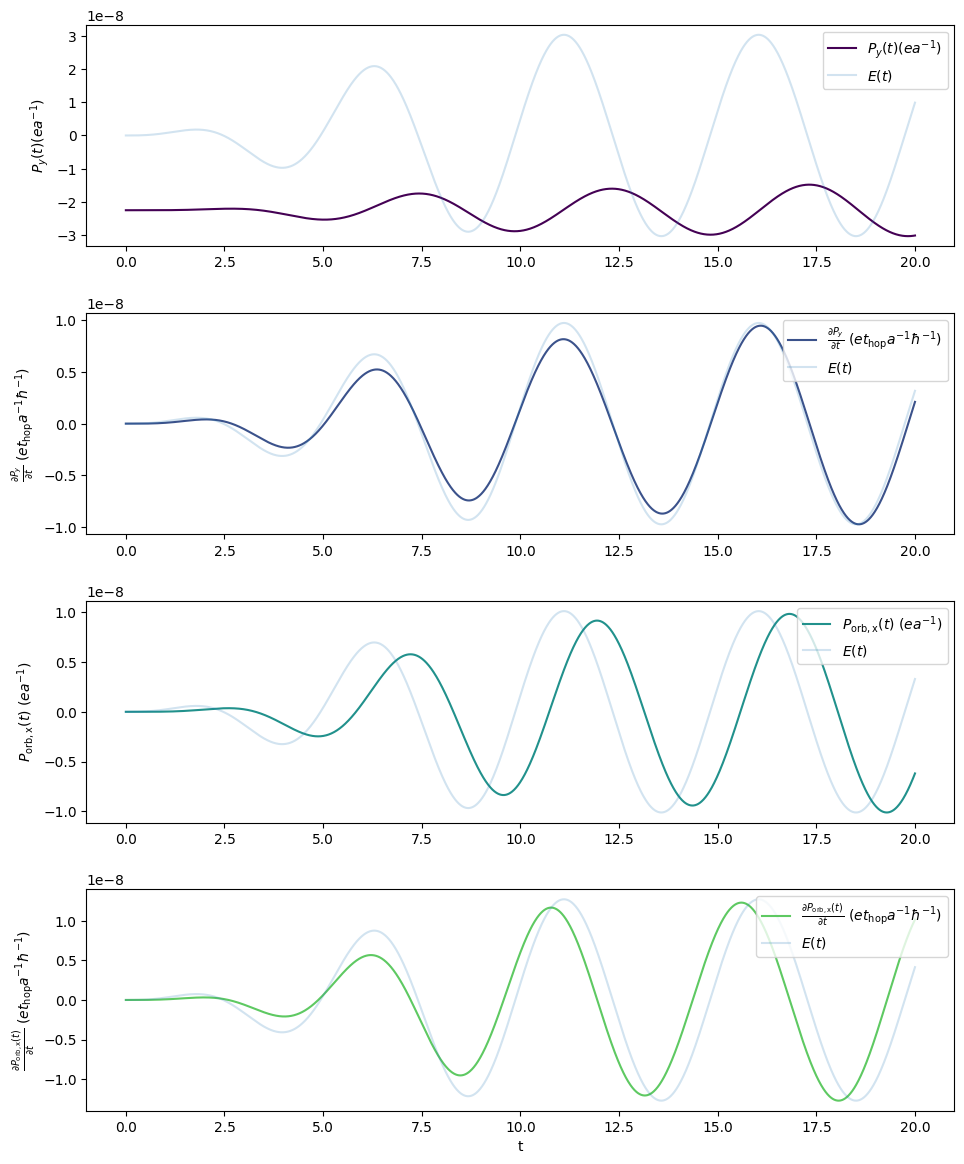

In [26]:
d.plot_simulation_time_series()

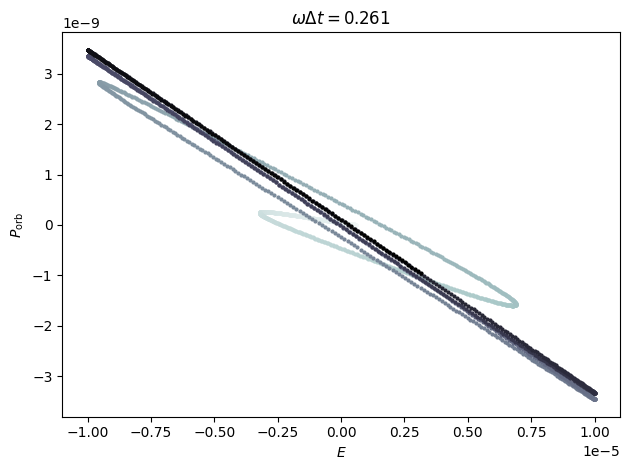

In [88]:
shift = 129
slice_length = len(l.states) - shift - 1
# slice_length = len(l.states) // 2

cmap = plt.get_cmap("bone_r")

for i, (e, p) in enumerate(zip(d.E[-slice_length:-1], (d.P_orb)[-slice_length-shift:-1-shift])):
    color = cmap(i / slice_length)
    plt.plot(e, p, ".", color=color, markersize=4)

# plt.plot(d.E[-slice_length:-1], d.P_orb[-slice_length-shift:-1-shift], "-")

plt.xlabel("$E$")
plt.ylabel("$P_{\\rm orb}$")

shift_w = shift * l.h * d.main_freq / (2 * np.pi)
plt.title(f"$\\omega\\Delta t = {shift_w:.3f}$")

plt.tight_layout()
plt.savefig("orb_hall_cond_13x41_r.pdf")
plt.show()


Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.
Occupation set to 0.50.


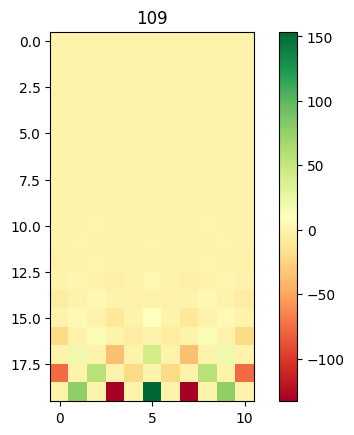

In [67]:
A = Lattice2D(
    HexagonalLatticeGeometry((11, 20)),
    SimulationParameters(
        t_hop=-1,
        E_amplitude=FieldAmplitudeGenerator.ramped_oscillation(E, omega, 2),
        E_direction=np.array([0, 1]),
        h=0.01,
        T=10,
        substeps=5,
    ),
)

A.set_fractional_occupation(0.5)
state = A.density_matrix.diagonal().reshape(A.geometry.dimensions[::-1])

i = A.N//2 -1
state = A.energy_states[:, i].reshape(A.geometry.dimensions[::-1])
state2 = A.energy_states[:, i+1].reshape(A.geometry.dimensions[::-1])

state -= state2

plt.imshow(state*A.N, cmap="RdYlGn")
plt.title(i)
plt.colorbar()
plt.show()

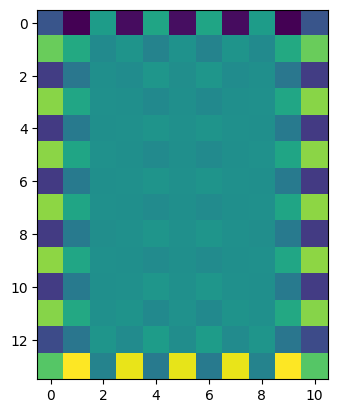

In [17]:
from matplotlib import animation
ims = []
fig, ax = plt.subplots()
s = 0
for i in range(s, len(l.states), 1):
    data = l.states[i].diagonal().real.reshape((14, 11))
    im = ax.imshow(data, animated=True)
    if i == s:
        ax.imshow(data)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)


ani.save("test3.mp4")

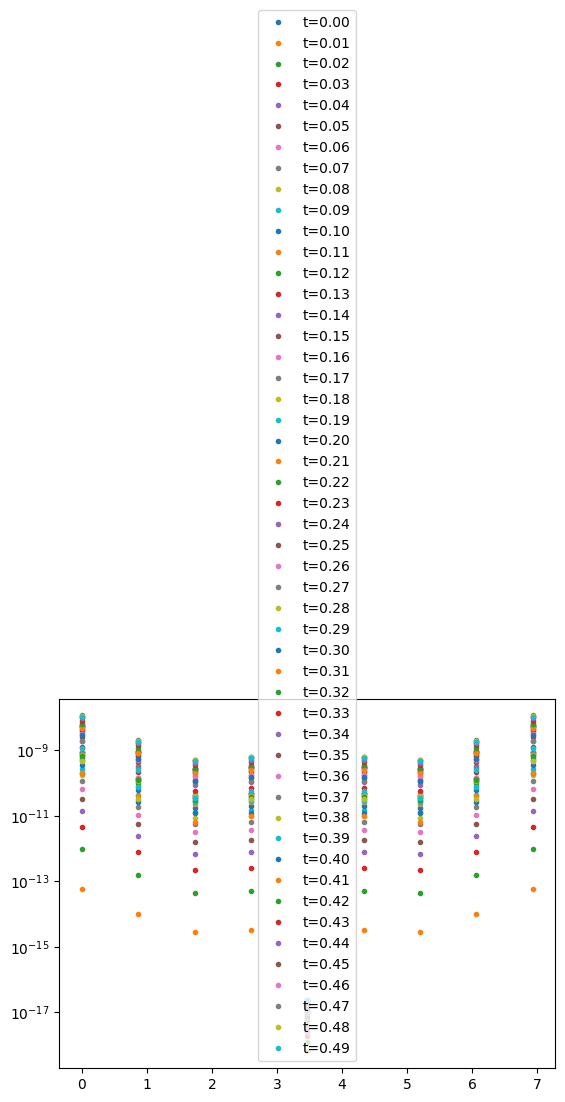

In [ ]:
for i in range(0, 50):
    plt.plot(
        d.P_orb_cols[i].keys(),
        d.P_orb_cols[i].values(),
        ".",
        label=f"t={i * d.dt:.2f}",
    )

plt.yscale("log")
plt.show()


In [ ]:
state = l.energy_states[:, 95]

for i in range(len(state)):
    x, y = l.geometry.site_to_position(i)
    if (x+y) % 2:
        state[i] = np.nan
        
fig, ax = plt.subplots(figsize=(l.Lx, l.Ly))
plot_site_grid(state, l.geometry, ax)
plot_site_connections(0.1*l.H_hop, l.geometry, ax, plot_flow_direction_arrows=False, label_connection_strength=False)

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 336/336 [00:25<00:00, 13.23it/s]


<Axes: >

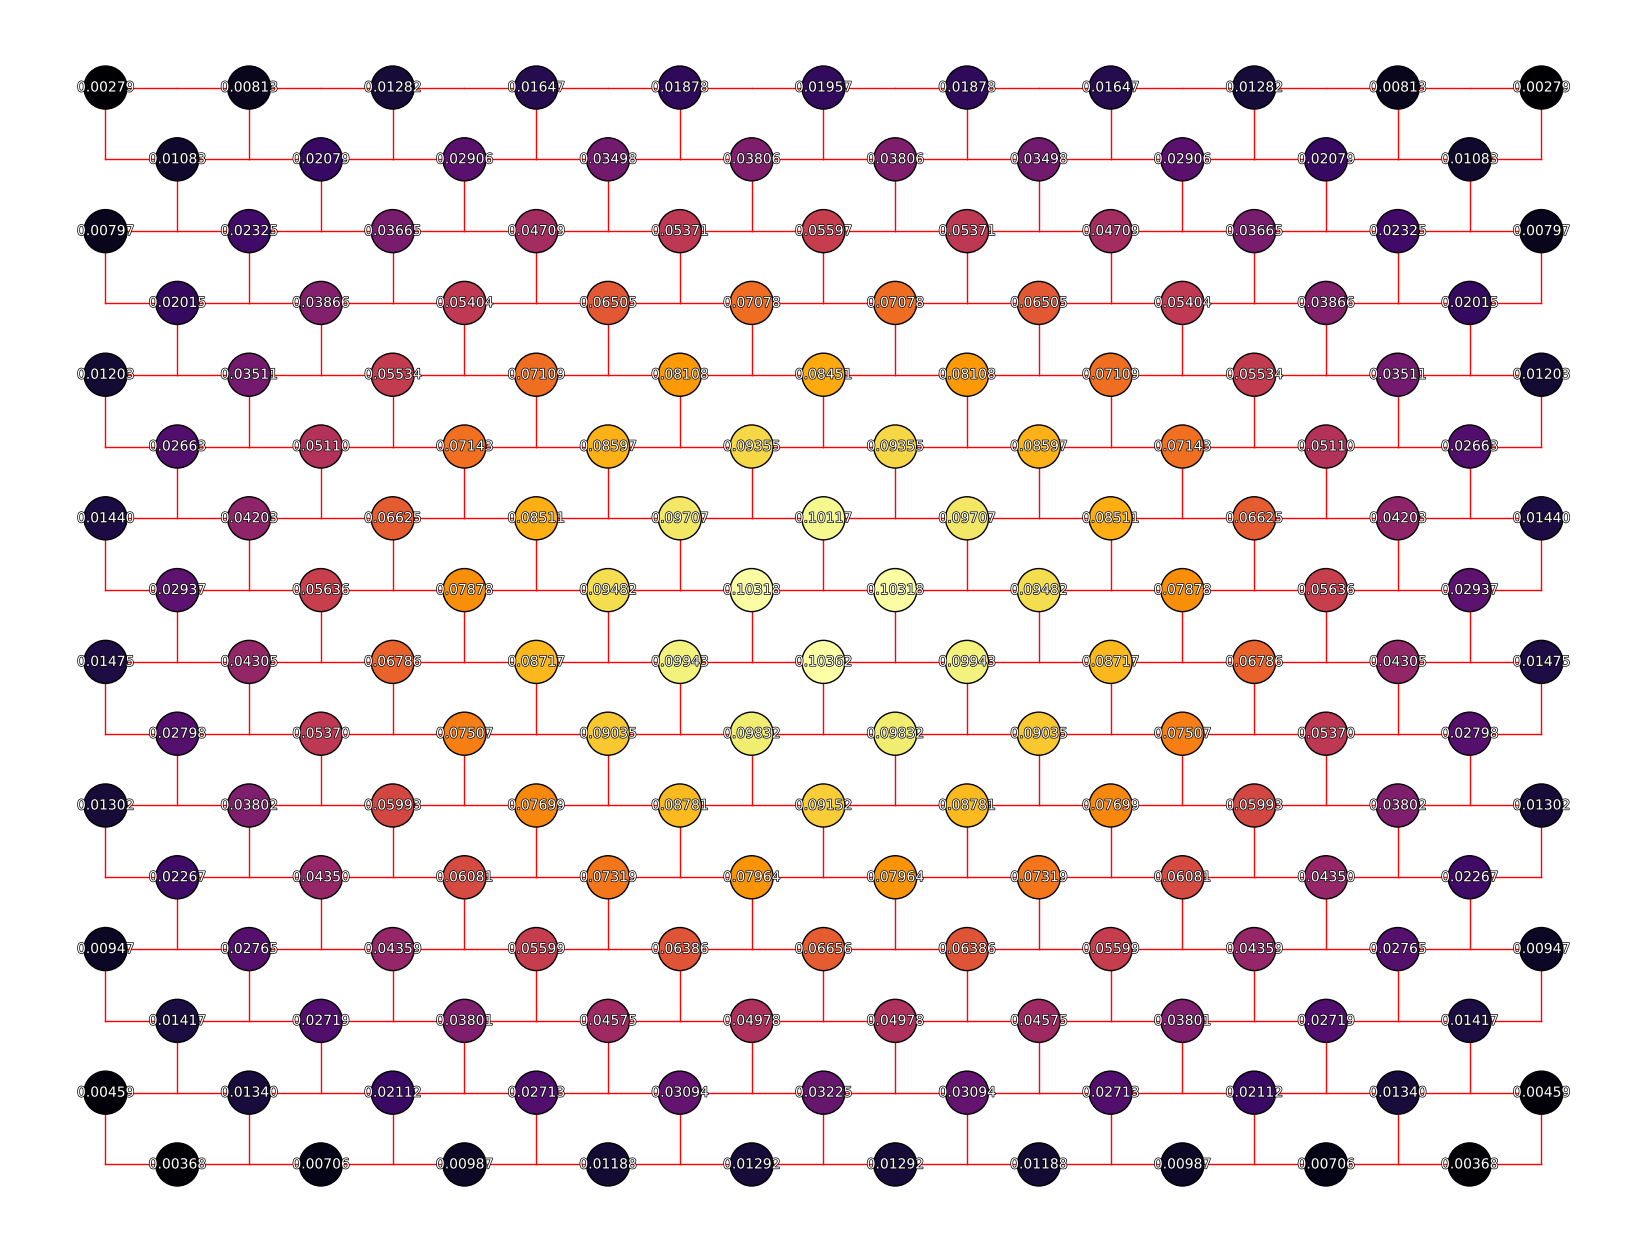

In [67]:
from lattice import plot_site_connections, plot_site_grid
from tqdm import trange
from scipy.optimize import curve_fit

l = Lattice2D(
    BrickwallLatticeGeometry((21, 16)),
    SimulationParameters.default(),
)


def get_cols(state, geometry):
    cols = dict()
    for i, val in enumerate(state):
        if val is None or np.isnan(val):
            continue
        x, y = geometry.site_to_position(i)
        cols[round(x, 2)] = cols.get(round(x, 2), []) + [val]
    return cols


K = []
AB = 0

for k in trange(len(l.eigen_energies)):
    state = l.energy_states[:, k]

    for i in range(len(state)):
        x, y = l.geometry.site_to_position(i)
        if (x + y) % 2 == AB:
            state[i] = np.nan
    # state[1::2] = np.nan
    abs_max_index = -1
    kk = []
    for x, col in get_cols(state, l.geometry).items():
        col = np.array(col)
        abs_max_index = np.nanargmax(np.abs(col))
        off = 0
        if AB == 0:
            off = -(x % 2)
        if abs(col[abs_max_index]) > 0.0001:
            col /= np.nanmax(np.abs(col)) * np.sign(col[0])

            def sine_func(x, j, A):
                A = 1
                return A * np.sin(j * x)
            
            off2 = 0
            if AB == 0:
                off2 = -1
            x_values = np.arange(0.5 * (AB + x % 2) + off - off2, len(col) + 0.5 * (AB + x % 2) + off-off2)
            # Initial guess for parameters 
            p0 = [0.5, 1]
            try:
                popt, pcov = curve_fit(sine_func, x_values, col, p0=p0, bounds=([-np.pi, -1], [np.pi, 1]))
                max_freq, A = abs(popt[0]), popt[1]
                # print(f"FFT freq: {freqs[max_idx]}, Fitted freq: {max_freq2}, Fitted A: {popt[1]}")
                error = np.sqrt(np.diag(pcov))
                if error[0] < 0.02:
                    kk.append(max_freq)
            except Exception as e:
                error = 1000
                max_freq, A = 2 * np.pi * (k + 1) / (l.geometry.Ly + 1), -1
                print(f"Error in curve fitting for {k}")
        
    
        
        plt.plot(np.arange(0.5 * (x % 2 + AB) + off, len(col) + 0.5 * (x % 2 * AB)+off), col + np.random.random() * 0.05, label=x)

    plt.legend()
    plt.title(f"Eigenstate {k} at {l.eigen_energies[k]} with {error}")

    if len(kk) > 2:
        max_freq = np.mean(kk)
        K.append(max_freq)
        plt.plot(x_values, sine_func(x_values, max_freq, A), "o-")
        plt.savefig(f"experiments/07-04_bw_B/{K[-1]}_{k}.png", dpi=150)

    plt.close()
    # plt.show()

fig, ax = plt.subplots(figsize=(l.Lx, l.Ly))
plot_site_grid(state, l.geometry, ax)
plot_site_connections(0.1 * l.H_hop, l.geometry, ax, plot_flow_direction_arrows=False, label_connection_strength=False)

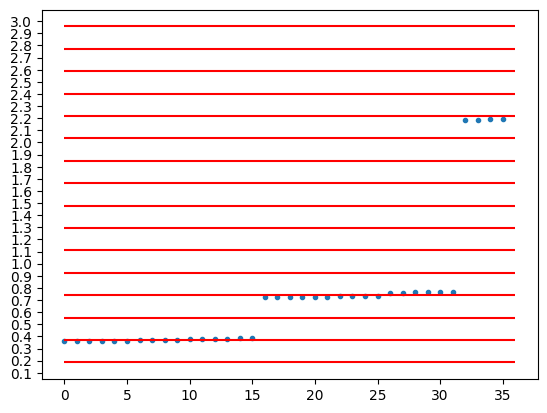

In [65]:
K.sort()
plt.plot(K, ".")
plt.yticks(np.arange(-1, np.pi, 0.1))
plt.hlines(np.arange(1, l.geometry.Ly+1)*np.pi/(l.geometry.Ly+1), 0, len(K), color="red", label="Theoretical")

Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


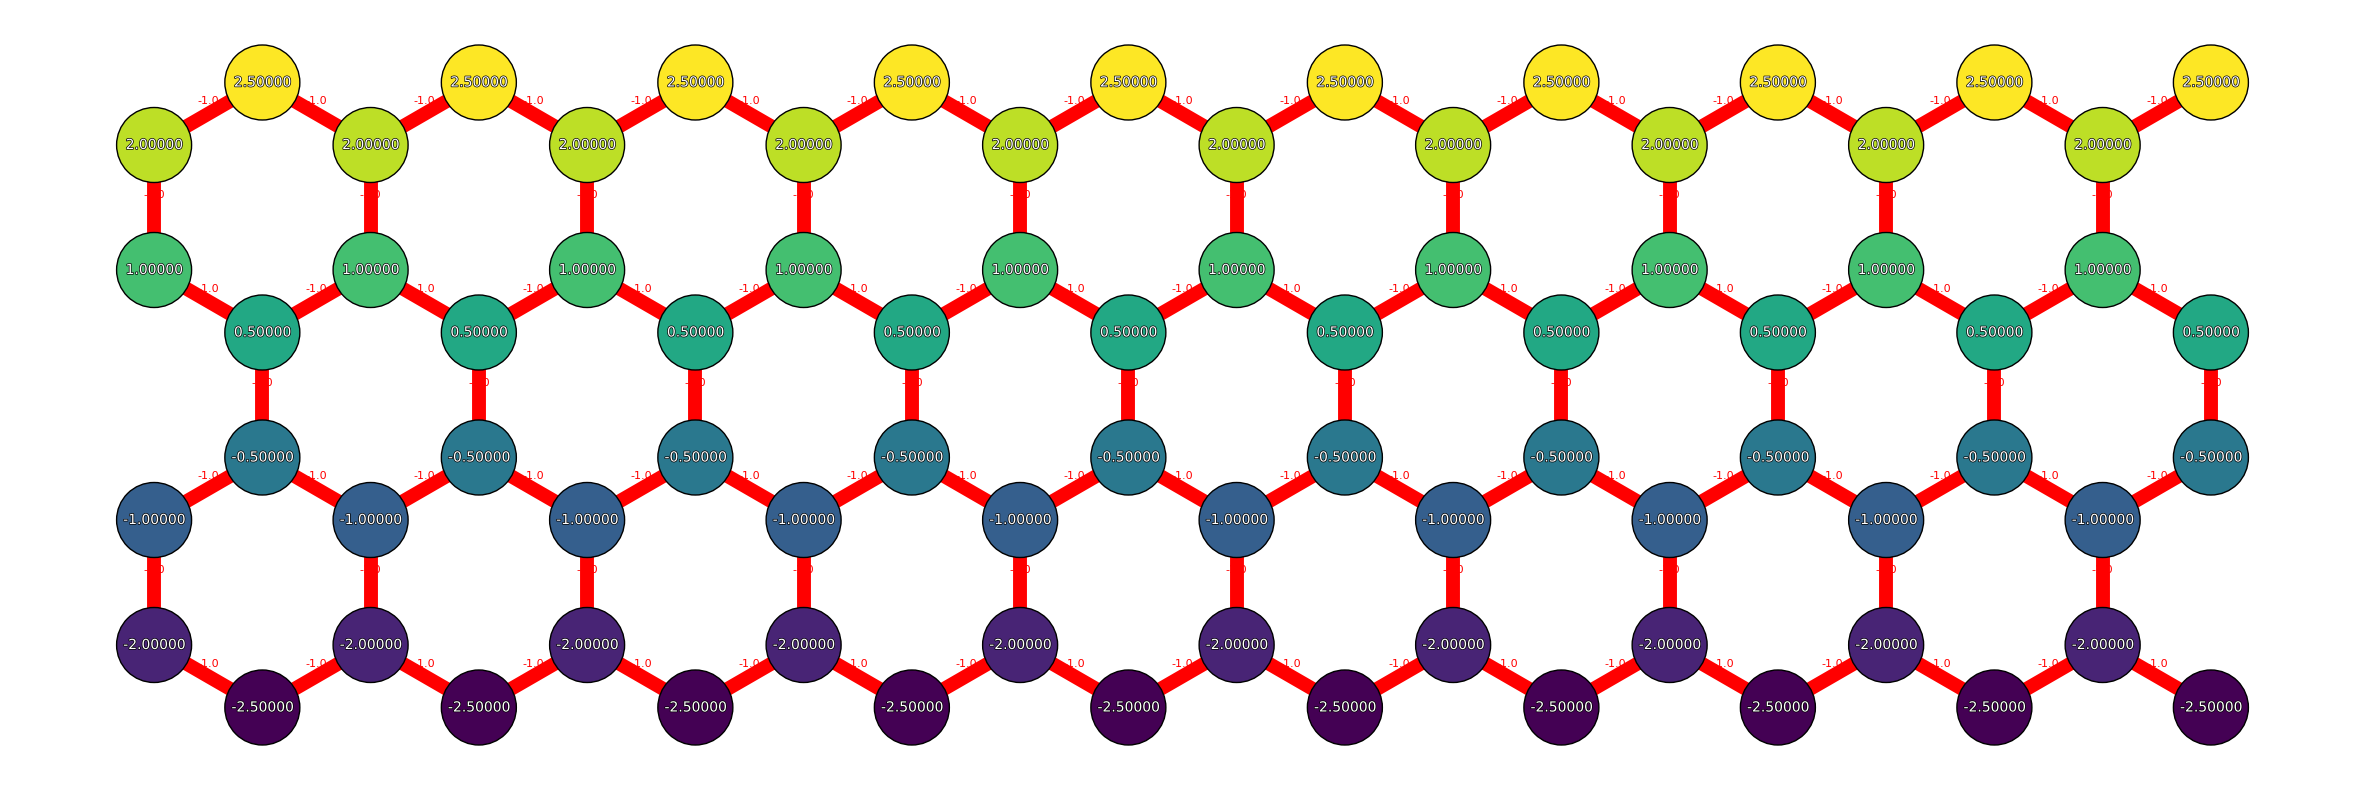

In [12]:
l = Lattice2D(
    HexagonalLatticeGeometry((20, 4)),
    SimulationParameters.default(),
)

l.plot_hamiltonian()